# Jun ??th, 2022 (Ent GABAN, 512 * 3)

**Motivation**: Make ent plots (KABA) <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.group import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def quick_show(data, vmin=0.1, vmax=None, figsize=None, cmap='magma'):
    num = max(len(tr['proj-top']) for tr in data.values())
    figsize = figsize if figsize else (12.8, 1.25 * len(data))
    fig, axes = create_figure(
        nrows=len(data),
        ncols=num,
        figsize=figsize,
        tight_layout=False,
        constrained_layout=True,
        reshape=True,
    )
 
    for i, (lbl, tr) in enumerate(data.items()):
        for j in range(num):
            ax = axes[i, j]
            if j >= len(tr['proj-top']):
                ax.remove()
            else:
                ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
                if np.nanmax(tr['proj-top'][j]) > 1:
                    _cmap = get_cluster_cmap(range(len(tr['proj-top']) - 1))
                    _vmax = None
                else:
                    _cmap = cmap
                    _vmax = vmax
                ax.imshow(
                    mwh(tr['proj-top'][j] < vmin, tr['proj-top'][j]),
                    cmap=_cmap, vmin=vmin, vmax=_vmax,
                )
                if j == 0:
                    ax.set_ylabel(lbl, fontsize=13)
    remove_ticks(axes)
    plt.show()

## Fig dir

In [3]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [4]:
mice = Mice(512)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

## task = 'rest', k = 10, p = 20

In [5]:
task = 'rest'

num_k, p = 10, 20
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [6]:
d2p = {}
# props_bo['num_k'] += 1
gr_bo = Group(**props_bo).fit_group()
gr_bo.avg()
d2p['bold'] = gr_bo.trim2d(gr_bo.project_vec())

pi_ca = {}
for b in [(0.01, 0.50), 0.5]:
    mice.setup_func_data(task, band_ca=b)
    gr_ca = Group(**props_ca).fit_group()
    gr_ca.avg()

    d2p[f'ca2\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())
    pi_ca[b] = gr_ca.pi

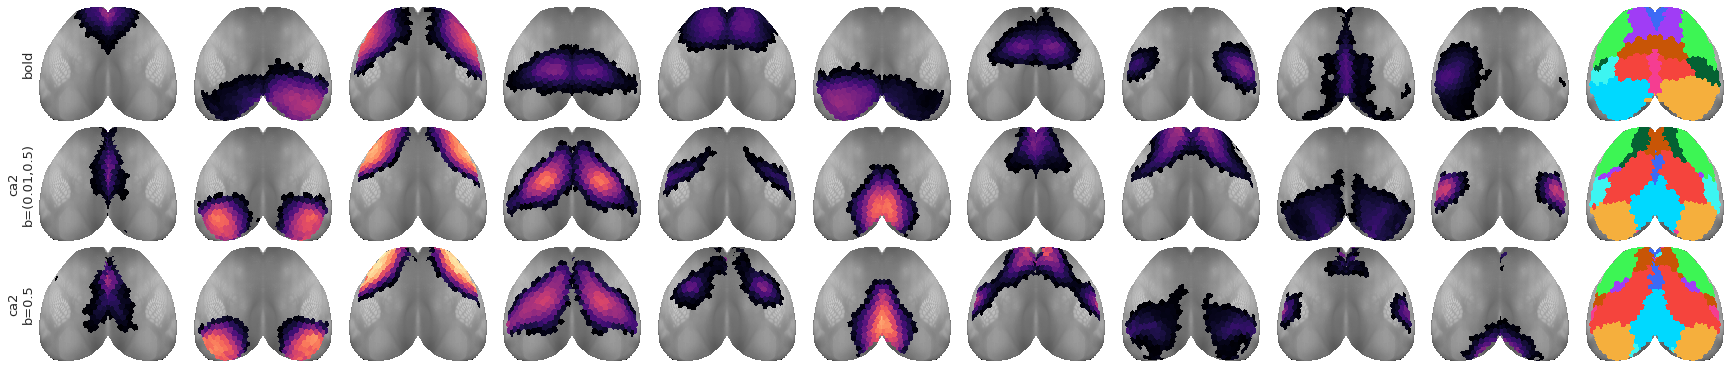

In [7]:
quick_show(d2p, vmin=0.1, vmax=1.0, figsize=(24, 5))

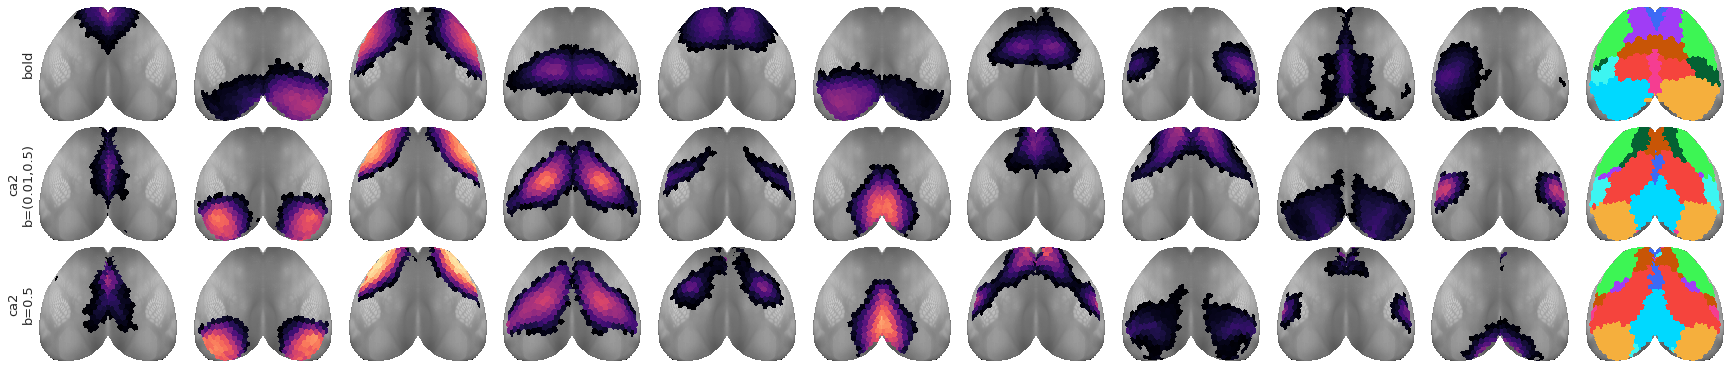

In [8]:
# CA2

b = 0.5
mice.setup_func_data(task, band_ca=b)
gr_ca = Group(**props_ca).fit_group()
# pi_ca = bn.nanmean(gr_ca.run_pi, )

h_ca2 = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(gr_ca.num_k)
h_avg_ca2 = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(h_ca2, 3), 2), 1), 0)

b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
gr_ca = Group(**props_ca).fit_group()
gr_ca.avg()

h_ca = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(gr_ca.num_k)
h_avg_ca = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(h_ca, 3), 2), 1), 0)


# BOLD

gr_bo = Group(**props_bo).fit_group()

h_bo = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(gr_bo.num_k)
h_avg_bo = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(h_bo, 3), 2), 1), 0)

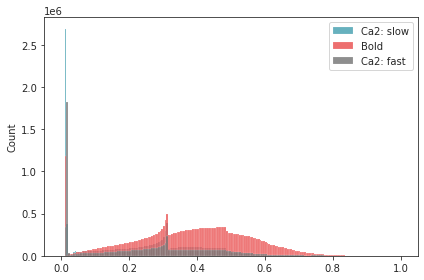

In [9]:
fig, ax = create_figure()
sns.histplot(h_ca[np.isfinite(h_ca)], color=pal['ca2'], label='Ca2: slow', bins=np.linspace(0, 1, 201), ax=ax)
sns.histplot(h_bo[np.isfinite(h_bo)], color=pal['bold-lite'], label='Bold', bins=np.linspace(0, 1, 201), ax=ax)
sns.histplot(h_ca2[np.isfinite(h_ca2)], color='dimgrey', label='Ca2: fast', bins=np.linspace(0, 1, 201), ax=ax)
ax.legend()
plt.show()

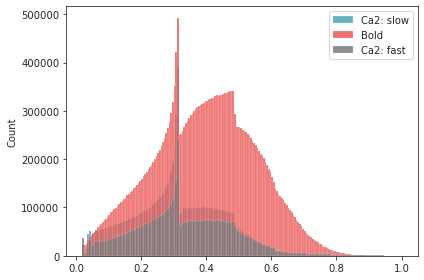

In [10]:
fig, ax = create_figure()
sns.histplot(h_ca[np.nonzero(h_ca)], color=pal['ca2'], label='Ca2: slow', bins=np.linspace(0.02, 1, 197), ax=ax)
sns.histplot(h_bo[np.nonzero(h_bo)], color=pal['bold-lite'], label='Bold', bins=np.linspace(0.02, 1, 197), ax=ax)
sns.histplot(h_ca2[np.nonzero(h_ca2)], color='dimgrey', label='Ca2: fast', bins=np.linspace(0.02, 1, 197), ax=ax)
ax.legend()
plt.show()

In [11]:
hr_ca = sp_stats.rankdata(h_ca, axis=-1)
hr_ca2 = sp_stats.rankdata(h_ca2, axis=-1)
hr_bo = sp_stats.rankdata(h_bo, axis=-1)

hr_ca[np.isnan(h_ca)] = np.nan
hr_ca2[np.isnan(h_ca2)] = np.nan
hr_bo[np.isnan(h_bo)] = np.nan

hr_ca = bn.nanmean(bn.nanmean(bn.nanmean(hr_ca, 2), 1), 0)
hr_ca2 = bn.nanmean(bn.nanmean(bn.nanmean(hr_ca2, 2), 1), 0)
hr_bo = bn.nanmean(bn.nanmean(bn.nanmean(hr_bo, 2), 1), 0)

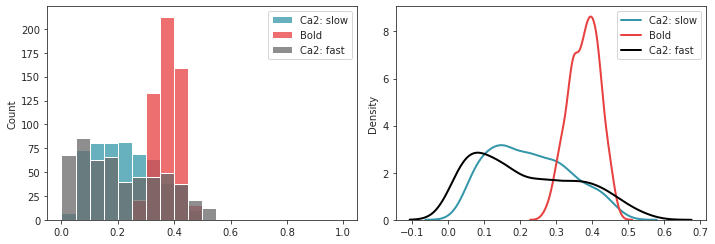

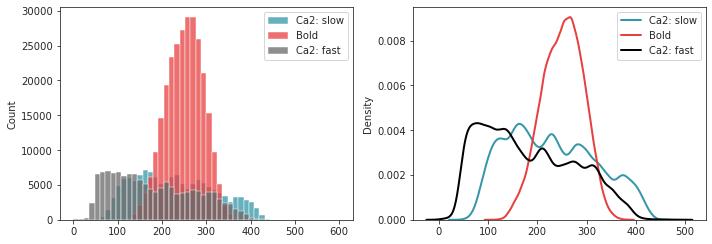

In [12]:
fig, axes = create_figure(1, 2, (10, 3.5))

sns.histplot(
    h_avg_ca[h_avg_ca.nonzero()],
    color=pal['ca2'],
    bins=np.linspace(0, 1, 21),
    label='Ca2: slow',
    ax=axes[0],
)
sns.histplot(
    h_avg_bo[h_avg_bo.nonzero()],
    color=pal['bold-lite'],
    bins=np.linspace(0, 1, 21),
    label='Bold',
    ax=axes[0],
)
sns.histplot(
    h_avg_ca2[h_avg_ca2.nonzero()],
    color='dimgrey',
    bins=np.linspace(0, 1, 21),
    label='Ca2: fast',
    ax=axes[0],
)
axes[0].legend()

sns.kdeplot(
    h_avg_ca[h_avg_ca.nonzero()],
    color=pal['ca2'],
    label='Ca2: slow',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    h_avg_bo[h_avg_bo.nonzero()],
    color=pal['bold-lite'],
    label='Bold',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    h_avg_ca2[h_avg_ca2.nonzero()],
    color='k',
    label='Ca2: fast',
    lw=2,
    ax=axes[1],
)
axes[1].legend()

plt.show()



fig, axes = create_figure(1, 2, (10, 3.5))

sns.histplot(
    hr_ca[hr_ca.nonzero()],
    color=pal['ca2'],
    bins=np.linspace(0, 600, 51),
    label='Ca2: slow',
    ax=axes[0],
)
sns.histplot(
    hr_bo[hr_bo.nonzero()],
    color=pal['bold-lite'],
    bins=np.linspace(0, 600, 51),
    label='Bold',
    ax=axes[0],
)
sns.histplot(
    hr_ca2[hr_ca2.nonzero()],
    color='dimgrey',
    bins=np.linspace(0, 600, 51),
    label='Ca2: fast',
    ax=axes[0],
)
axes[0].legend()

sns.kdeplot(
    hr_ca[hr_ca.nonzero()],
    color=pal['ca2'],
    label='Ca2: slow',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    hr_bo[hr_bo.nonzero()],
    color=pal['bold-lite'],
    label='Bold',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    hr_ca2[hr_ca2.nonzero()],
    color='k',
    label='Ca2: fast',
    lw=2,
    ax=axes[1],
)
axes[1].legend()

plt.show()

In [27]:
trh_ca2 = gr_ca.trim2d(gr_ca.project_vec(h_avg_ca2, add_disjoint=False))
trh_ca = gr_ca.trim2d(gr_ca.project_vec(h_avg_ca, add_disjoint=False))
trh_bo = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo, add_disjoint=False))

vmin = min(np.nanmin(h_avg_ca2), np.nanmin(h_avg_ca), np.nanmin(h_avg_bo))
vmax = max(np.nanmax(h_avg_ca2), np.nanmax(h_avg_ca), np.nanmax(h_avg_bo))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}
vmin, vmax

(0.015186031874244638, 0.5527828698535096)

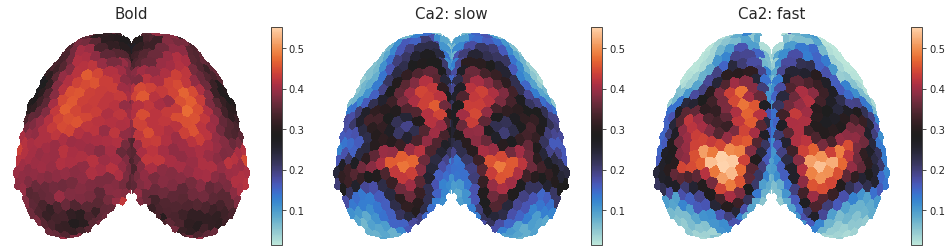

In [28]:
fig, axes = create_figure(1, 3, (13.5, 3.4))

im = axes[0].imshow(mwh(trh_bo['proj-top'][0] < vmin, trh_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trh_ca['proj-top'][0] < vmin, trh_ca['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trh_ca2['proj-top'][0] < vmin, trh_ca2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

<matplotlib.image.AxesImage object at 0x7fc9a71c33d0>

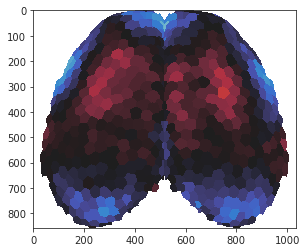

In [37]:
plt.imshow(mwh(trh_bo['proj-top'][0] < 0.2, trh_bo['proj-top'][0]), vmin=0.23, vmax=0.55, cmap='icefire')

In [83]:
kws = {'task': task, 'band_ca': (0.01, 0.5)}
deg_df = pd.concat([
    make_degree_df(mice, 'ca2', **kws),
    make_degree_df(mice, 'bold-lite', **kws),
])

In [92]:
_df = deg_df[
    (deg_df['mode'] == 'ca2') &
    (deg_df['density'] == 20) &
    (deg_df['weighted'] == 0)
]
deg_ca = _df.pivot_table(values='degree', index='key', columns='node').values

_df = deg_df[
    (deg_df['mode'] == 'bold-lite') &
    (deg_df['density'] == 20) &
    (deg_df['weighted'] == 0)
]
deg_bo = _df.pivot_table(values='degree', index='key', columns='node').values

<AxesSubplot:>

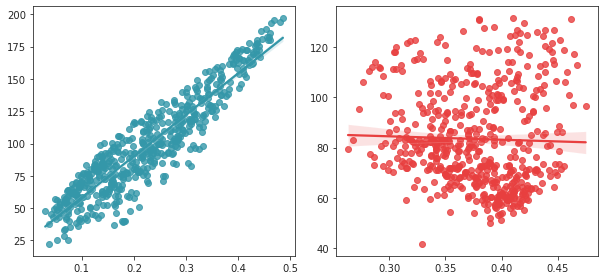

In [93]:
fig, axes = create_figure(1, 2, (8.5, 4))
sns.regplot(h_avg_ca, bn.nanmean(deg_ca, 0), color=pal['ca2'], ax=axes[0])
sns.regplot(h_avg_bo, bn.nanmean(deg_bo, 0), color=pal['bold-lite'], ax=axes[1])

In [100]:
sp_stats.pearsonr(h_avg_ca, bn.nanmean(deg_ca, 0))

(0.9232844327546855, 1.5148255535144402e-226)

In [101]:
sp_stats.pearsonr(h_avg_bo, bn.nanmean(deg_bo, 0))

(-0.02920158571232563, 0.4975091528063631)

In [13]:
# CA2

b = 0.5
mice.setup_func_data(task, band_ca=b)
gr_ca = Group(**props_ca).fit_group()
# pi_ca = bn.nanmean(gr_ca.run_pi, )

h_ca2 = sp_stats.entropy(bn.nanmean(gr_ca.run_pi, -3), axis=-2) / np.log(gr_ca.num_k)
h_avg_ca2 = bn.nanmean(bn.nanmean(bn.nanmean(h_ca2, 2), 1), 0)

b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
gr_ca = Group(**props_ca).fit_group()
gr_ca.avg()

h_ca = sp_stats.entropy(bn.nanmean(gr_ca.run_pi, -3), axis=-2) / np.log(gr_ca.num_k)
h_avg_ca = bn.nanmean(bn.nanmean(bn.nanmean(h_ca, 2), 1), 0)


# BOLD

gr_bo = Group(**props_bo).fit_group()

h_bo = sp_stats.entropy(bn.nanmean(gr_bo.run_pi, -3), axis=-2) / np.log(gr_bo.num_k)
h_avg_bo = bn.nanmean(bn.nanmean(bn.nanmean(h_bo, 2), 1), 0)

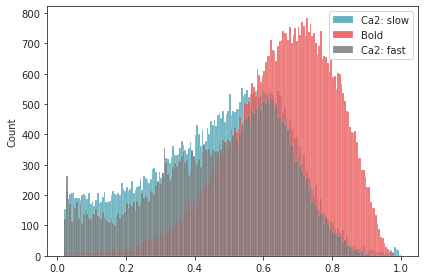

In [14]:
fig, ax = create_figure()
sns.histplot(h_ca[np.nonzero(h_ca)], color=pal['ca2'], label='Ca2: slow', bins=np.linspace(0.02, 1, 197), ax=ax)
sns.histplot(h_bo[np.nonzero(h_bo)], color=pal['bold-lite'], label='Bold', bins=np.linspace(0.02, 1, 197), ax=ax)
sns.histplot(h_ca2[np.nonzero(h_ca2)], color='dimgrey', label='Ca2: fast', bins=np.linspace(0.02, 1, 197), ax=ax)
ax.legend()
plt.show()

In [16]:
kws = {'task': task, 'band_ca': (0.01, 0.5)}
deg_df = pd.concat([
    make_degree_df(mice, 'ca2', **kws),
    make_degree_df(mice, 'bold-lite', **kws),
])

In [17]:
_df = deg_df[
    (deg_df['mode'] == 'ca2') &
    (deg_df['density'] == 20) &
    (deg_df['weighted'] == 0)
]
deg_ca = _df.pivot_table(values='degree', index='key', columns='node').values

_df = deg_df[
    (deg_df['mode'] == 'bold-lite') &
    (deg_df['density'] == 20) &
    (deg_df['weighted'] == 0)
]
deg_bo = _df.pivot_table(values='degree', index='key', columns='node').values

<AxesSubplot:>

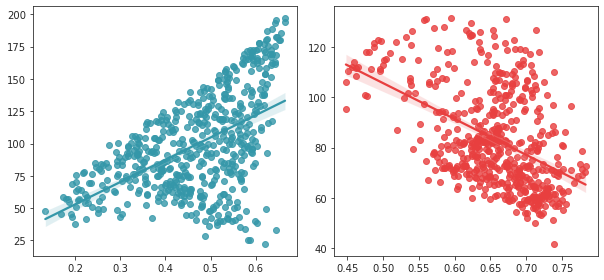

In [18]:
fig, axes = create_figure(1, 2, (8.5, 4))
sns.regplot(h_avg_ca, bn.nanmean(deg_ca, 0), color=pal['ca2'], ax=axes[0])
sns.regplot(h_avg_bo, bn.nanmean(deg_bo, 0), color=pal['bold-lite'], ax=axes[1])

### Pr 95

In [32]:
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
gr_ca = Group(**props_ca).fit_group()
pruned_ca = gr_ca.prune(thres=0.003, ci=0.95)
pi_ca, _ = gr_ca.align_post_prune(pruned_ca['pi_prune_run'])


gr_bo = Group(**props_bo).fit_group()
pruned_bo = gr_bo.prune(thres=0.003, ci=0.95)
pi_bo, _ = gr_bo.align_post_prune(pruned_bo['pi_prune_run'])

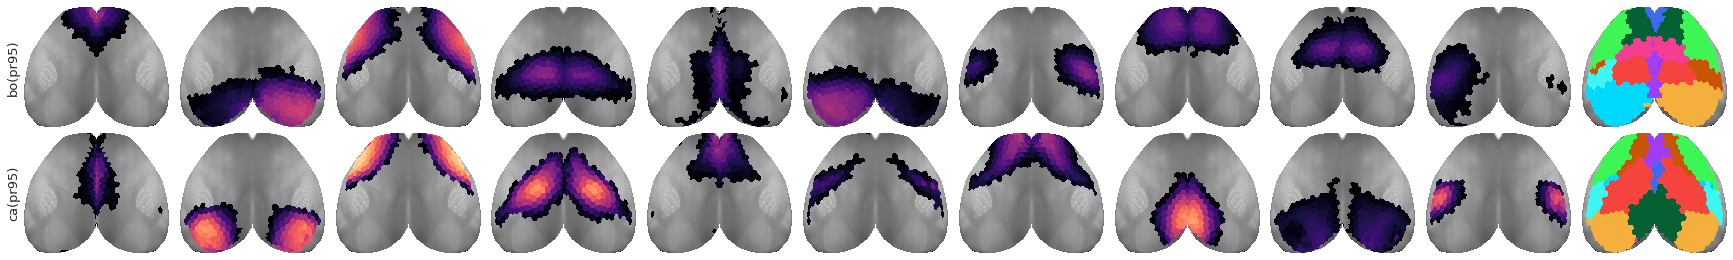

In [55]:
d2p = {
    'bo(pr95)': gr_bo.trim2d(gr_bo.project_vec(apply_fn(pi_bo))),
    'ca(pr95)': gr_ca.trim2d(gr_ca.project_vec(apply_fn(pi_ca))),
}
quick_show(d2p, vmin=0.1, vmax=1.0, figsize=(24, 3.5))

In [71]:
h_ca = sp_stats.entropy(pi_ca, axis=-2) / np.log(gr_ca.num_k)
h_bo = sp_stats.entropy(pi_bo, axis=-2) / np.log(gr_bo.num_k)
h_ca_avg = apply_fn(h_ca, 1)
h_bo_avg = apply_fn(h_bo, 1)

<AxesSubplot:>

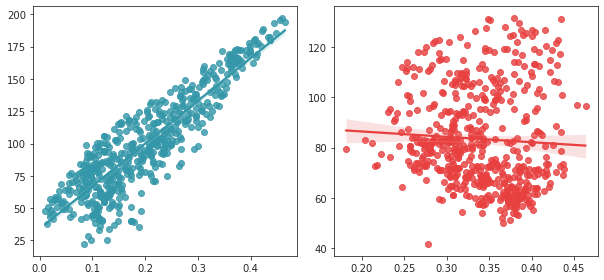

In [72]:
fig, axes = create_figure(1, 2, (8.5, 4))
sns.regplot(h_ca_avg, bn.nanmean(deg_ca, 0), color=pal['ca2'], ax=axes[0])
sns.regplot(h_bo_avg, bn.nanmean(deg_bo, 0), color=pal['bold-lite'], ax=axes[1])

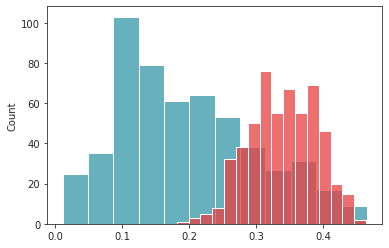

In [73]:
sns.histplot(h_ca_avg, color=pal['ca2'])
sns.histplot(h_bo_avg, color=pal['bold-lite'])
plt.show()

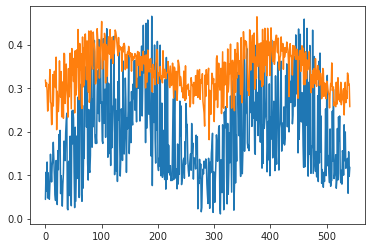

In [75]:
plt.plot(h_ca_avg)
plt.plot(h_bo_avg);

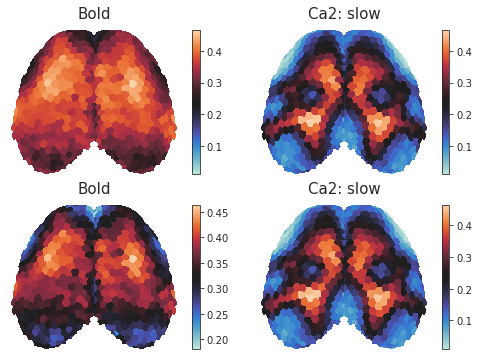

In [76]:
trh_ca = gr_ca.trim2d(gr_ca.project_vec(h_ca_avg, add_disjoint=False))
trh_bo = gr_bo.trim2d(gr_bo.project_vec(h_bo_avg, add_disjoint=False))

fig, axes = create_figure(2, 2, (7, 5))

vmin = min(np.nanmin(h_ca_avg), np.nanmin(h_bo_avg))
vmax = max(np.nanmax(h_ca_avg), np.nanmax(h_bo_avg))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}

im = axes[0, 0].imshow(mwh(trh_bo['proj-top'][0] < vmin, trh_bo['proj-top'][0]), **kw_im)
axes[0, 0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0, 0])

im = axes[0, 1].imshow(mwh(trh_ca['proj-top'][0] < vmin, trh_ca['proj-top'][0]), **kw_im)
axes[0, 1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0, 1])

kw_im = {
    'vmin': None,
    'vmax': None,
    'cmap': 'icefire',
}

im = axes[1, 0].imshow(mwh(trh_bo['proj-top'][0] < vmin, trh_bo['proj-top'][0]), **kw_im)
axes[1, 0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1, 0])

im = axes[1, 1].imshow(mwh(trh_ca['proj-top'][0] < vmin, trh_ca['proj-top'][0]), **kw_im)
axes[1, 1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1, 1])

remove_ticks(axes)
plt.show()

### Pr 99 for Bold

In [85]:
gr_bo = Group(**props_bo).fit_group()
pruned_bo = gr_bo.prune(thres=0.003, ci=0.99)
pi_bo, _ = gr_bo.align_post_prune(pruned_bo['pi_prune_run'])

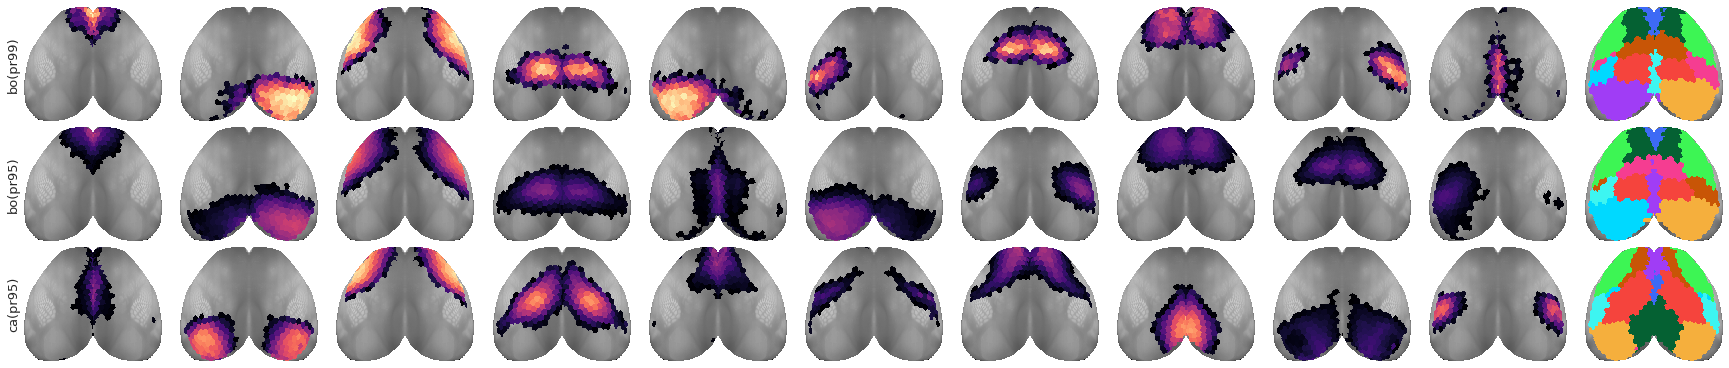

In [86]:
d2p = {
    'bo(pr99)': gr_bo.trim2d(gr_bo.project_vec(apply_fn(pi_bo))),
    **d2p,
}
quick_show(d2p, vmin=0.1, vmax=1.0, figsize=(24, 5))

In [87]:
h_bo = sp_stats.entropy(pi_bo, axis=-2) / np.log(gr_bo.num_k)
h_bo_avg = apply_fn(h_bo, 1)

<AxesSubplot:>

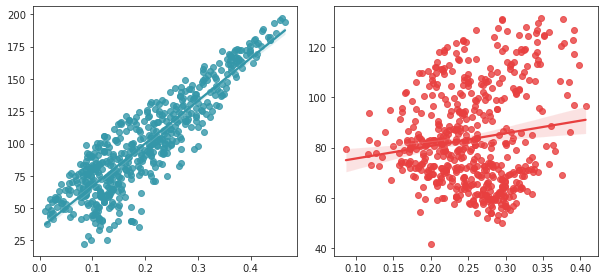

In [88]:
fig, axes = create_figure(1, 2, (8.5, 4))
sns.regplot(h_ca_avg, bn.nanmean(deg_ca, 0), color=pal['ca2'], ax=axes[0])
sns.regplot(h_bo_avg, bn.nanmean(deg_bo, 0), color=pal['bold-lite'], ax=axes[1])

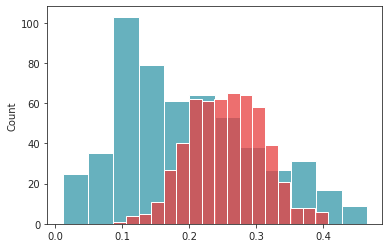

In [89]:
sns.histplot(h_ca_avg, color=pal['ca2'])
sns.histplot(h_bo_avg, color=pal['bold-lite'])
plt.show()

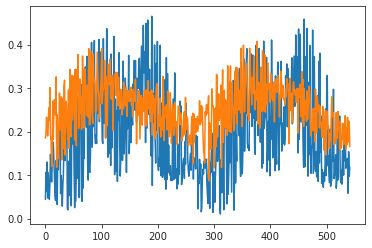

In [90]:
plt.plot(h_ca_avg)
plt.plot(h_bo_avg);

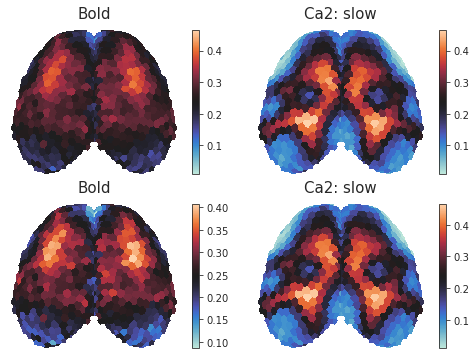

In [91]:
trh_ca = gr_ca.trim2d(gr_ca.project_vec(h_ca_avg, add_disjoint=False))
trh_bo = gr_bo.trim2d(gr_bo.project_vec(h_bo_avg, add_disjoint=False))

fig, axes = create_figure(2, 2, (7, 5))

vmin = min(np.nanmin(h_ca_avg), np.nanmin(h_bo_avg))
vmax = max(np.nanmax(h_ca_avg), np.nanmax(h_bo_avg))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}

im = axes[0, 0].imshow(mwh(trh_bo['proj-top'][0] < vmin, trh_bo['proj-top'][0]), **kw_im)
axes[0, 0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0, 0])

im = axes[0, 1].imshow(mwh(trh_ca['proj-top'][0] < vmin, trh_ca['proj-top'][0]), **kw_im)
axes[0, 1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0, 1])

kw_im = {
    'vmin': None,
    'vmax': None,
    'cmap': 'icefire',
}

im = axes[1, 0].imshow(mwh(trh_bo['proj-top'][0] < vmin, trh_bo['proj-top'][0]), **kw_im)
axes[1, 0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1, 0])

im = axes[1, 1].imshow(mwh(trh_ca['proj-top'][0] < vmin, trh_ca['proj-top'][0]), **kw_im)
axes[1, 1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1, 1])

remove_ticks(axes)
plt.show()

### OLD STUFF

In [18]:
trhr_ca2 = gr_ca.trim2d(gr_ca.project_vec(hr_ca2, add_disjoint=False))
trhr_ca = gr_ca.trim2d(gr_ca.project_vec(hr_ca, add_disjoint=False))
trhr_bo = gr_ca.trim2d(gr_bo.project_vec(hr_bo, add_disjoint=False))

vmin = min(np.nanmin(hr_ca2), np.nanmin(hr_ca), np.nanmin(hr_bo))
vmax = max(np.nanmax(hr_ca2), np.nanmax(hr_ca), np.nanmax(hr_bo))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}
vmin, vmax

(24.85648148148148, 453.575)

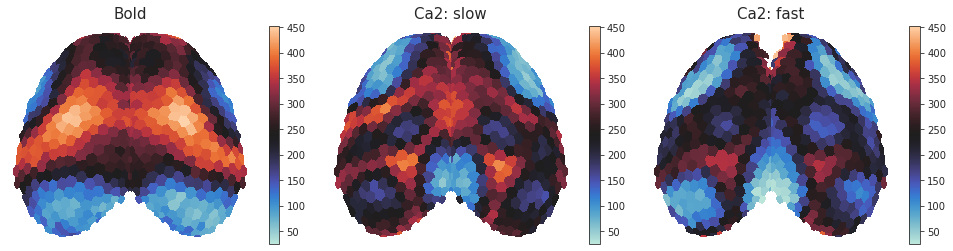

In [19]:
fig, axes = create_figure(1, 3, (13.5, 3.4))

im = axes[0].imshow(mwh(trhr_bo['proj-top'][0] < vmin, trhr_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trhr_ca['proj-top'][0] < vmin, trhr_ca['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trhr_ca2['proj-top'][0] < vmin, trhr_ca2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

<AxesSubplot:ylabel='Count'>

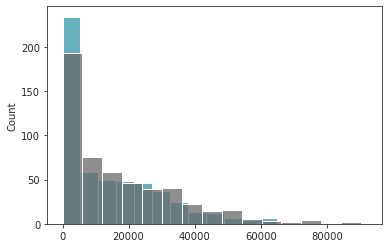

In [20]:
delta_ca = (hr_bo - hr_ca) ** 2
delta_ca2 = (hr_bo - hr_ca2) ** 2

sns.histplot(delta_ca, color=pal['ca2'])
sns.histplot(delta_ca2, color='dimgrey')

In [21]:
tr_delta = gr_ca.trim2d(gr_ca.project_vec(delta_ca, add_disjoint=False))
tr_delta2 = gr_ca.trim2d(gr_ca.project_vec(delta_ca2, add_disjoint=False))

vmin = min(np.nanmin(delta_ca), np.nanmin(delta_ca2))
vmax = max(np.nanmax(delta_ca), np.nanmax(delta_ca2))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'hot',
}
vmin, vmax

(0.0010204475308644599, 92040.13603347432)

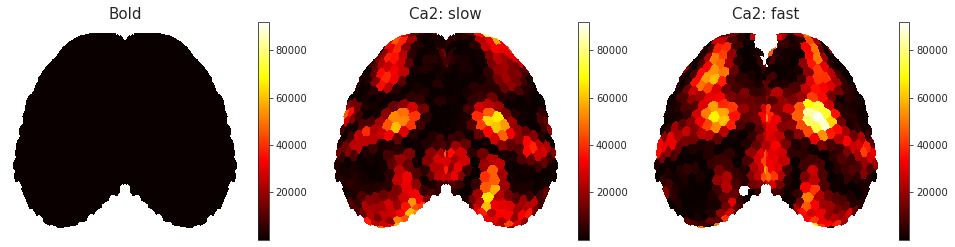

In [22]:
fig, axes = create_figure(1, 3, (13.5, 3.4))

im = axes[0].imshow(mwh(trh_bo['proj-top'][0] < vmin, trh_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(tr_delta['proj-top'][0] < vmin, tr_delta['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(tr_delta2['proj-top'][0] < vmin, tr_delta2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

## True comparison

In [224]:
task = 'rest'

num_k, p = 7, 10
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}


d2p = {}
gr_bo = Group(**props_bo).fit_group()
gr_bo.avg()
d2p['bold'] = gr_bo.trim2d(gr_bo.project_vec())

# prune 95
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3))
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
d2p['bold\npr95'] = gr_bo.trim2d(gr_bo.project_vec())

# prune 99
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.99)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
d2p['bold\npr99'] = gr_bo.trim2d(gr_bo.project_vec())

pi_ca = {}
for b in [0.5, (0.01, 0.50)]:
    mice.setup_func_data(task, band_ca=b)
    gr_ca = Group(**props_ca).fit_group()
    gr_ca.avg()
    
    pr_ca = gr_ca.prune(n_resamples=int(7e3))
    gr_ca.run_pi = pr_ca['pi_prune_run']
    gr_ca.pi = pr_ca['pi_prune_avg']

    d2p[f'ca2\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())
    pi_ca[b] = gr_ca.pi

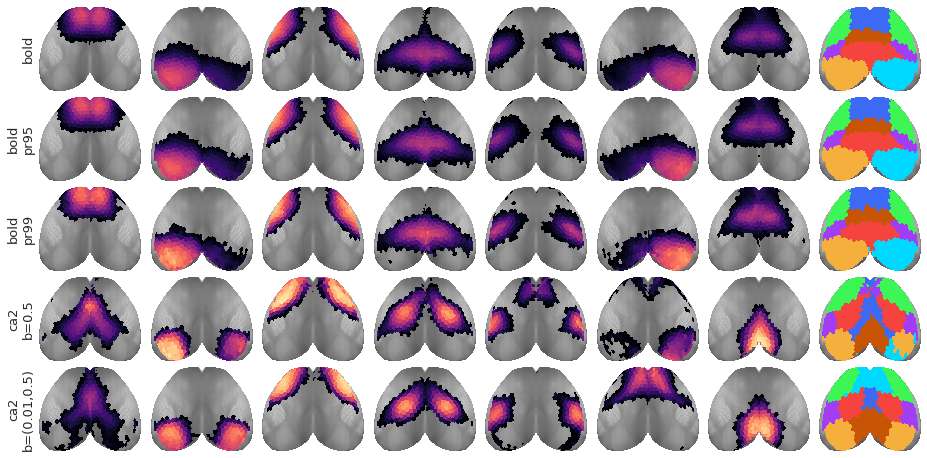

In [225]:
quick_show(d2p, vmin=0.1, vmax=1.0)

In [226]:
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
gr_ca = Group(**props_ca).fit_group()
gr_ca.avg()

pr_ca = gr_ca.prune(n_resamples=int(7e3))
h_ca = sp_stats.entropy(pr_ca['pi_prune_run'], axis=-2) / np.log(gr_ca.num_k)
h_avg_ca = bn.nanmean(bn.nanmean(bn.nanmean(h_ca, 2), 1), 0)


b = 0.5
mice.setup_func_data(task, band_ca=b)
gr_ca2 = Group(**props_ca).fit_group()
gr_ca2.avg()

pr_ca2 = gr_ca2.prune(n_resamples=int(7e3))
h_ca2 = sp_stats.entropy(pr_ca2['pi_prune_run'], axis=-2) / np.log(gr_ca2.num_k)
h_avg_ca2 = bn.nanmean(bn.nanmean(bn.nanmean(h_ca2, 2), 1), 0)

gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.95)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
_ = gr_bo._merge_vis(0.05)

h_bo = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(gr_bo.num_k)
h_avg_bo = bn.nanmean(bn.nanmean(bn.nanmean(h_bo, 2), 1), 0)

In [227]:
hr_ca = sp_stats.rankdata(h_ca, axis=-1)
hr_ca2 = sp_stats.rankdata(h_ca2, axis=-1)
hr_bo = sp_stats.rankdata(h_bo, axis=-1)

hr_ca[np.isnan(h_ca)] = np.nan
hr_ca2[np.isnan(h_ca2)] = np.nan
hr_bo[np.isnan(h_bo)] = np.nan

hr_ca = bn.nanmean(bn.nanmean(bn.nanmean(hr_ca, 2), 1), 0)
hr_ca2 = bn.nanmean(bn.nanmean(bn.nanmean(hr_ca2, 2), 1), 0)
hr_bo = bn.nanmean(bn.nanmean(bn.nanmean(hr_bo, 2), 1), 0)

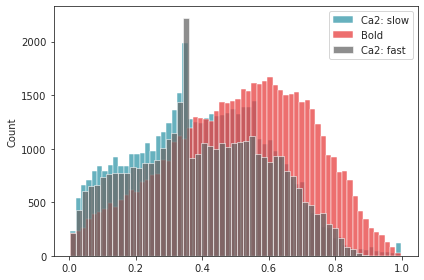

In [228]:
fig, ax = create_figure()
sns.histplot(h_ca[h_ca.nonzero()], color=pal['ca2'], label='Ca2: slow', ax=ax)
sns.histplot(h_bo[h_bo.nonzero()], color=pal['bold-lite'], label='Bold', ax=ax)
sns.histplot(h_ca2[h_ca2.nonzero()], color='dimgrey', label='Ca2: fast', ax=ax)
ax.legend()
plt.show()

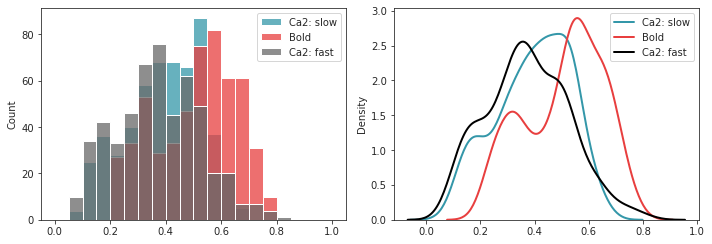

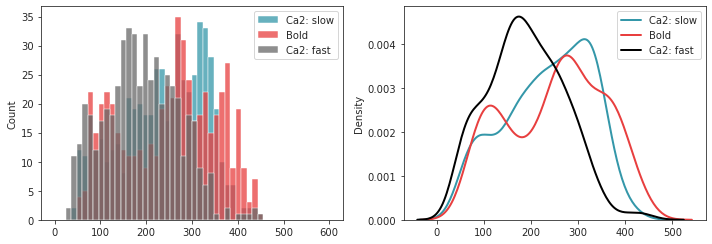

In [229]:
fig, axes = create_figure(1, 2, (10, 3.5))

sns.histplot(
    h_avg_ca[h_avg_ca.nonzero()],
    color=pal['ca2'],
    bins=np.linspace(0, 1, 21),
    label='Ca2: slow',
    ax=axes[0],
)
sns.histplot(
    h_avg_bo[h_avg_bo.nonzero()],
    color=pal['bold-lite'],
    bins=np.linspace(0, 1, 21),
    label='Bold',
    ax=axes[0],
)
sns.histplot(
    h_avg_ca2[h_avg_ca2.nonzero()],
    color='dimgrey',
    bins=np.linspace(0, 1, 21),
    label='Ca2: fast',
    ax=axes[0],
)
axes[0].legend()

sns.kdeplot(
    h_avg_ca[h_avg_ca.nonzero()],
    color=pal['ca2'],
    label='Ca2: slow',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    h_avg_bo[h_avg_bo.nonzero()],
    color=pal['bold-lite'],
    label='Bold',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    h_avg_ca2[h_avg_ca2.nonzero()],
    color='k',
    label='Ca2: fast',
    lw=2,
    ax=axes[1],
)
axes[1].legend()

plt.show()



fig, axes = create_figure(1, 2, (10, 3.5))

sns.histplot(
    hr_ca[hr_ca.nonzero()],
    color=pal['ca2'],
    bins=np.linspace(0, 600, 51),
    label='Ca2: slow',
    ax=axes[0],
)
sns.histplot(
    hr_bo[hr_bo.nonzero()],
    color=pal['bold-lite'],
    bins=np.linspace(0, 600, 51),
    label='Bold',
    ax=axes[0],
)
sns.histplot(
    hr_ca2[hr_ca2.nonzero()],
    color='dimgrey',
    bins=np.linspace(0, 600, 51),
    label='Ca2: fast',
    ax=axes[0],
)
axes[0].legend()

sns.kdeplot(
    hr_ca[hr_ca.nonzero()],
    color=pal['ca2'],
    label='Ca2: slow',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    hr_bo[hr_bo.nonzero()],
    color=pal['bold-lite'],
    label='Bold',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    hr_ca2[hr_ca2.nonzero()],
    color='k',
    label='Ca2: fast',
    lw=2,
    ax=axes[1],
)
axes[1].legend()

plt.show()

In [230]:
trh_ca2 = gr_ca.trim2d(gr_ca.project_vec(h_avg_ca2, add_disjoint=False))
trh_ca = gr_ca.trim2d(gr_ca.project_vec(h_avg_ca, add_disjoint=False))
trh_bo = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo, add_disjoint=False))

vmin = min(np.nanmin(h_avg_ca2), np.nanmin(h_avg_ca), np.nanmin(h_avg_bo))
vmax = max(np.nanmax(h_avg_ca2), np.nanmax(h_avg_ca), np.nanmax(h_avg_bo))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}
vmin, vmax

(0.05842478874172021, 0.824015174009396)

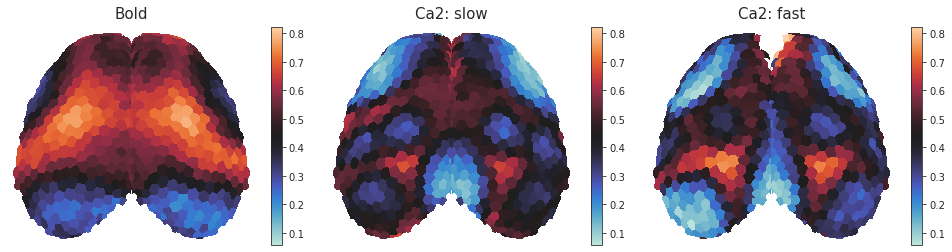

In [231]:
fig, axes = create_figure(1, 3, (13.5, 3.4))

im = axes[0].imshow(mwh(trh_bo['proj-top'][0] < vmin, trh_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trh_ca['proj-top'][0] < vmin, trh_ca['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trh_ca2['proj-top'][0] < vmin, trh_ca2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

In [232]:
trhr_ca2 = gr_ca.trim2d(gr_ca.project_vec(hr_ca2, add_disjoint=False))
trhr_ca = gr_ca.trim2d(gr_ca.project_vec(hr_ca, add_disjoint=False))
trhr_bo = gr_ca.trim2d(gr_bo.project_vec(hr_bo, add_disjoint=False))

vmin = min(np.nanmin(hr_ca2), np.nanmin(hr_ca), np.nanmin(hr_bo))
vmax = max(np.nanmax(hr_ca2), np.nanmax(hr_ca), np.nanmax(hr_bo))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}
vmin, vmax

(28.56867283950617, 454.3333333333333)

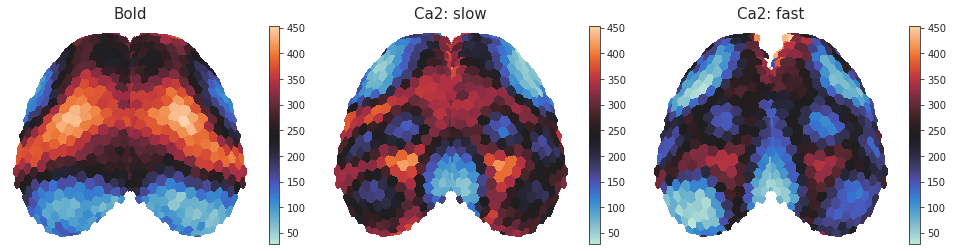

In [233]:
fig, axes = create_figure(1, 3, (13.5, 3.4))

im = axes[0].imshow(mwh(trhr_bo['proj-top'][0] < vmin, trhr_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trhr_ca['proj-top'][0] < vmin, trhr_ca['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trhr_ca2['proj-top'][0] < vmin, trhr_ca2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

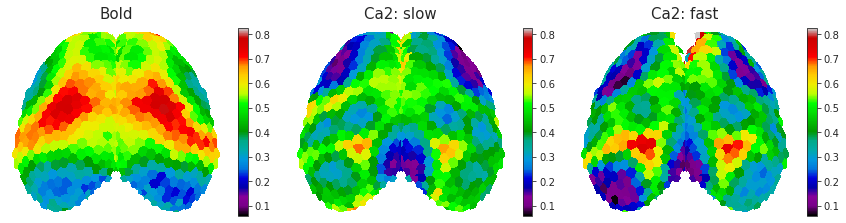

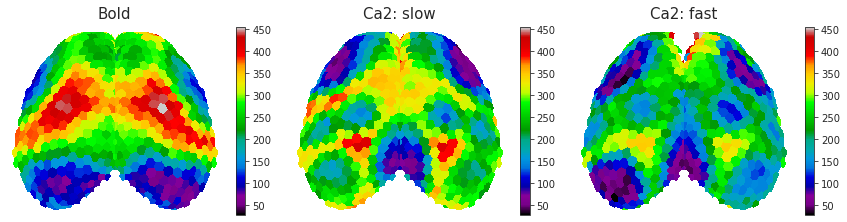

In [234]:
cmap = 'nipy_spectral'

vmin = min(np.nanmin(h_avg_ca2), np.nanmin(h_avg_ca), np.nanmin(h_avg_bo))
vmax = max(np.nanmax(h_avg_ca2), np.nanmax(h_avg_ca), np.nanmax(h_avg_bo))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': cmap,
}

fig, axes = create_figure(1, 3, (12, 3.))

im = axes[0].imshow(mwh(trh_bo['proj-top'][0] < vmin, trh_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trh_ca['proj-top'][0] < vmin, trh_ca['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trh_ca2['proj-top'][0] < vmin, trh_ca2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()



vmin = min(np.nanmin(hr_ca2), np.nanmin(hr_ca), np.nanmin(hr_bo))
vmax = max(np.nanmax(hr_ca2), np.nanmax(hr_ca), np.nanmax(hr_bo))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': cmap,
}

fig, axes = create_figure(1, 3, (12, 3.))

im = axes[0].imshow(mwh(trhr_bo['proj-top'][0] < vmin, trhr_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trhr_ca['proj-top'][0] < vmin, trhr_ca['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trhr_ca2['proj-top'][0] < vmin, trhr_ca2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

<AxesSubplot:ylabel='Count'>

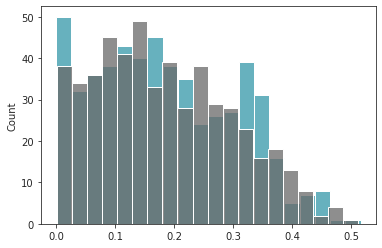

In [235]:
delta_ca = np.abs(h_avg_bo - h_avg_ca)
delta_ca2 = np.abs(h_avg_bo - h_avg_ca2)

sns.histplot(delta_ca, color=pal['ca2'], bins=20)
sns.histplot(delta_ca2, color='dimgrey', bins=20)

<AxesSubplot:ylabel='Count'>

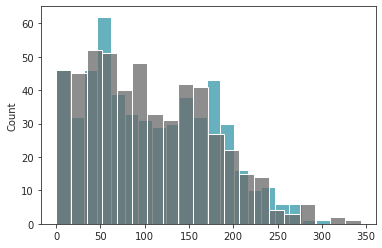

In [236]:
delta_ca = np.abs(hr_bo - hr_ca)
delta_ca2 = np.abs(hr_bo - hr_ca2)

sns.histplot(delta_ca, color=pal['ca2'], bins=20)
sns.histplot(delta_ca2, color='dimgrey', bins=20)

In [237]:
bn.nanmean(delta_ca), bn.nanmean(delta_ca2)

(107.56058144621629, 105.26633390808507)

In [238]:
tr_delta = gr_ca.trim2d(gr_ca.project_vec(delta_ca, add_disjoint=False))
tr_delta2 = gr_ca.trim2d(gr_ca.project_vec(delta_ca2, add_disjoint=False))

vmin = min(np.nanmin(delta_ca), np.nanmin(delta_ca2))
vmax = max(np.nanmax(delta_ca), np.nanmax(delta_ca2))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'hot',
}
vmin, vmax

(0.07037037037036953, 343.58333333333337)

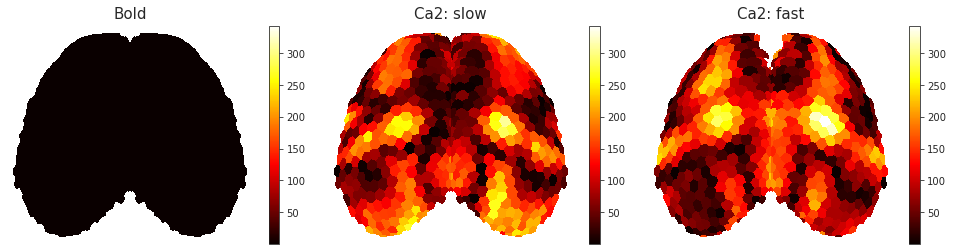

In [239]:
fig, axes = create_figure(1, 3, (13.5, 3.4))

im = axes[0].imshow(mwh(trh_bo['proj-top'][0] == 0, trh_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(tr_delta['proj-top'][0] < vmin, tr_delta['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(tr_delta2['proj-top'][0] < vmin, tr_delta2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

In [261]:
h_ca.shape, h_bo.shape

((10, 3, 4, 542), (10, 3, 4, 542))

In [262]:
y1 = h_bo.reshape(-1, h_bo.shape[-1])
y2 = h_ca.reshape(-1, h_ca.shape[-1])
good = ~np.logical_or(np.isnan(y1), np.isnan(y2))
y1.shape, y2.shape, good.shape

((120, 542), (120, 542), (120, 542))

<AxesSubplot:ylabel='Count'>

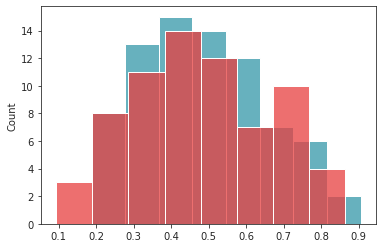

In [263]:
i = 35
sns.histplot(y1[:, i], color=pal['ca2'])
sns.histplot(y2[:, i], color=pal['bold-lite'])

[<matplotlib.lines.Line2D object at 0x7fef87d59670>]

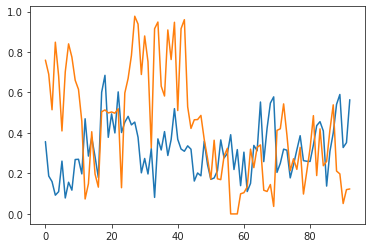

In [264]:
i = 79
plt.plot(y1[:, i][good[:, i]])
plt.plot(y2[:, i][good[:, i]])

In [265]:
sp_stats.pearsonr(y1[:, i][good[:, i]], y2[:, i][good[:, i]])

(-0.08809445125627942, 0.4010786513633593)

In [282]:
import sklearn

In [283]:
sklearn.__version__

'0.24.2'

In [266]:
def statistic(a, b, axis):
    return bn.nanmean(a - b, axis=axis)

In [267]:
test = sp_stats.permutation_test(
    data=(y1, y2),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e3),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

<AxesSubplot:ylabel='Count'>

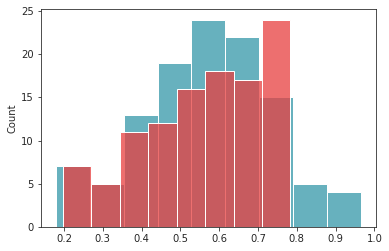

In [268]:
i = 176
sns.histplot(y1[:, i], color=pal['ca2'])
sns.histplot(y2[:, i], color=pal['bold-lite'])

<AxesSubplot:ylabel='Count'>

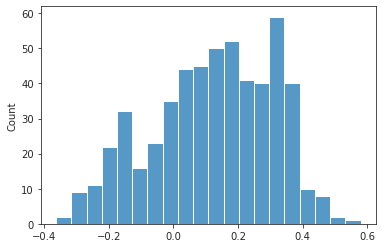

In [269]:
sns.histplot(test.statistic, bins=20)

In [270]:
tr_statistic = gr_ca.project_vec(test.statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue = gr_ca.project_vec(test.pvalue, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue = gr_ca.trim2d(tr_pvalue)

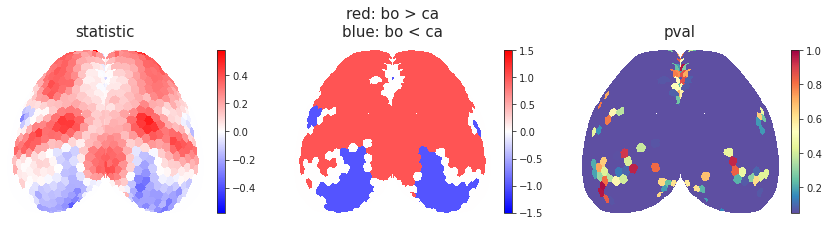

In [271]:
fig, axes = create_figure(1, 3, (12, 3))

vminmax = np.max(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue['proj-top'][0] > 0.05] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bo > ca\nblue: bo < ca', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue['top'] == 0, tr_pvalue['proj-top'][0]),
    cmap='Spectral_r', vmin=0.05, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

In [272]:
hr_ca = sp_stats.rankdata(h_ca, axis=-1)
hr_ca2 = sp_stats.rankdata(h_ca2, axis=-1)
hr_bo = sp_stats.rankdata(h_bo, axis=-1)

hr_ca[np.isnan(h_ca)] = np.nan
hr_ca2[np.isnan(h_ca2)] = np.nan
hr_bo[np.isnan(h_bo)] = np.nan

In [273]:
hr_ca.shape, hr_bo.shape

((10, 3, 4, 542), (10, 3, 4, 542))

In [274]:
y1 = hr_bo.reshape(-1, hr_bo.shape[-1])
y2 = hr_ca.reshape(-1, hr_ca.shape[-1])
y1.shape, y2.shape

((120, 542), (120, 542))

In [254]:
test = sp_stats.permutation_test(
    data=(y1, y2),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e3),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

In [255]:
tr_statistic = gr_ca.project_vec(test.statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue = gr_ca.project_vec(test.pvalue, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue = gr_ca.trim2d(tr_pvalue)

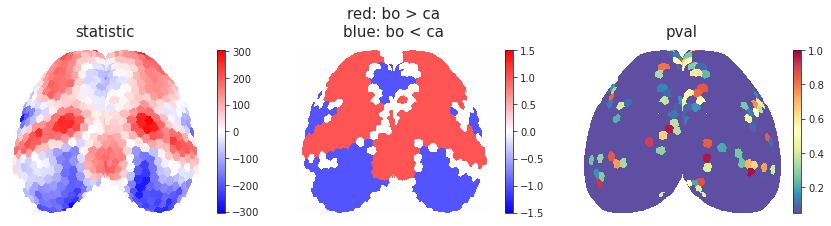

In [256]:
fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.max(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
im = axes[1].imshow(
    mwh(tr_pvalue['proj-top'][0] >= alpha, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bo > ca\nblue: bo < ca', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue['top'] == 0, tr_pvalue['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

In [277]:
sp_stats.spearmanr(h_avg_ca, h_avg_bo)

SpearmanrResult(correlation=0.11798135638447303, pvalue=0.005959885277039225)

In [280]:
sp_stats.spearmanr(h_avg_ca2[np.isfinite(h_avg_ca2)], h_avg_bo[np.isfinite(h_avg_ca2)])

SpearmanrResult(correlation=0.3678790886401121, pvalue=3.321423654642781e-18)